Load comptetion files

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
#------------------------------------------------------------------------------------------
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
# !pip install -q wordcloud
import wordcloud
#Same as in assignment1, for preprocessing of text
!python -m spacy download el_core_news_lg
import spacy as sp#tokeniser, parser tagger for greek language
import unicodedata #character properties for all Unicode characters
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#!pip install greek-stemmer-pos
#from greek_stemmer import stemmer

#Greek Stemmer by Giorgos Marios Patelis based on the work of Georgios Ntais
%run /kaggle/input/greek-stemmer/GreekStemmer.ipynb
#--------------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score as skf1
from torchmetrics.functional import f1_score
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

device = 'cpu'
print('Working on:', device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.6/568.6 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Working on: cpu


In [2]:
#hello there my name is jimmy#jsonpath1 = 'lem.json'
jsonpath2 = 'stem.json'
#jsonpath1 = '/kaggle/input/json-files/lem.json'
#jsonpath2 = '/kaggle/input/json-files/stem.json'
path = '/kaggle/input/ys19-2023-assignment-3/test_set.csv'
test_set = pd.read_csv(path) 
path = '/kaggle/input/ys19-2023-assignment-3/valid_set.csv'
valid_set = pd.read_csv(path) #4 columns id, text, sentiment, party
path = '/kaggle/input/ys19-2023-assignment-3/train_set.csv'
train_set = pd.read_csv(path)
#Making sure dataset is balanced
counts = train_set['Sentiment'].value_counts()
print(counts)


Sentiment
NEUTRAL     12210
NEGATIVE    12210
POSITIVE    12210
Name: count, dtype: int64


Data pre-processing functions + concatenation of train and valid sets.
We will split them later for training

In [3]:
#Data Pre-Processing, same as in assignment1 
nlp = sp.load("el_core_news_lg")

#Load stop words
def stopwords_list():
    with open('/kaggle/input/greek-stwords/Greek-Stopwords.txt') as f:
        # return the split results, which is all the words in the file.
        return f.read().split()
    
#Remove Stop Words Function
def rem_stopwords(text):
    stop_words = stopwords_list()
    for word in stop_words: 
         word = word.replace('\n', '')
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)



#Lemmatisation
def lemmatisation(text):
    doc = nlp(text)
    ret = []
    for token in doc:
        ret.append(token.lemma_)
    return ' '.join(ret)


#Stemming
#Using Greek Stemmer by Giorgos Marios Patelis based on the work of Georgios Ntais
def stemming(text):
    ret = []
    textupper = text.upper()
    
    tokenised_text = nltk.word_tokenize(textupper)
    for tok in tokenised_text:
        ret.append(stemWord(tok))
    textupper = ' '.join(ret)
    return textupper

#Concatenate sets
frames = [train_set, valid_set]
complete_train_set = pd.concat(frames).drop_duplicates().reset_index(drop=True)
complete_train_set.head(5)

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


Data pre-processing, leave only greek words, no punctuation

In [4]:
#Clean training data
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes
complete_train_set['Text'] = [r.upper() for r in complete_train_set['Text'] ]   #making everything uppercase
complete_train_set['Text'] = [''.join([c for c in unicodedata.normalize('NFD', r) if not unicodedata.combining(c)]) for r in complete_train_set['Text']] #removing accents
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub(r'@\w+', '', r)) #remove mentions
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub(r'([^α-ωΑ-Ω\s-])', ' ', r)) #only keeping greek letters, URLs are also removed this way
complete_train_set['Text'] = complete_train_set['Text'].apply(lambda r: re.sub('-', '',r)) #remove - character
complete_train_set['Text'] = complete_train_set['Text'].apply(rem_stopwords) #remove stopwords
print("Done")

Done


In [5]:
complete_train_set.head(5)

,New_ID,Text,Sentiment,Party
0,35027,ΑΠΟΛΥΜΑΝΣΗ ΚΟΡΙΟΙ ΑΠΕΝΤΟΜΩΣΗ ΚΟΡΙΟΣ ΑΠΟΛΥΜΑΝΣΕ...,NEUTRAL,SYRIZA
1,9531,ΕΞΙ ΝΕΕΣ ΕΠΙΣΤΟΛΕΣ ΜΑΚΕΔΟΝΙΑ ΚΑΙΝΕ ΝΔ ΜΗΤΣΟΤΑΚ...,NEGATIVE,ND
2,14146,ΙΣΧΥΡΟ ΚΚΕ ΔΥΝΑΜΗ ΛΑΟΥ ΒΟΥΛΗ ΚΑΘΗΜΕΡΙΝΟΥΣ ΑΓΩΝΕΣ,POSITIVE,KKE
3,28716,ΜΝΗΜΟΝΙΑΚΟΤΑΤΟ ΜΕΡΑ ΕΚΛΟΓΕΣ ΚΚΕ,NEUTRAL,KKE
4,32886,ΣΥΓΚΛΟΝΙΣΤΙΚΟ ΨΥΧΑΣΘΕΝΕΙΑ ΤΣΙΠΡΑ,NEUTRAL,SYRIZA


Data stemming, to improve vectorization

In [6]:
#Apply stemming on data 
stemmed = complete_train_set.copy(deep=True)
stemmed['Text'] = stemmed['Text'].apply(stemming)
stemmed.to_json(jsonpath2) #saving processed data as to not repeat this time consuming step

In [7]:
stemmed = pd.read_json(jsonpath2)   
stemmed.head(5)

,New_ID,Text,Sentiment,Party
0,35027,ΑΠΟΛΥΜΑΝΣ ΚΟΡΙ ΑΠΕΝΤΟΜΩΣ ΚΟΡΙ ΑΠΟΛΥΜΑΝΣ ΚΟΡΙ Κ...,NEUTRAL,SYRIZA
1,9531,ΕΞΙ ΝΕ ΕΠΙΣΤΟΛ ΜΑΚΕΔΟΝ ΚΑΙΝ ΝΔ ΜΗΤΣΟΤΑΚ ΓΝΩΡΙΖ...,NEGATIVE,ND
2,14146,ΙΣΧΥΡ ΚΚΕ ΔΥΝΑΜ ΛΑ ΒΟΥΛ ΚΑΘΗΜΕΡΙΝ ΑΓΩΝ,POSITIVE,KKE
3,28716,ΜΝΗΜΟΝΙΑΚ ΜΕΡ ΕΚΛΟΓ ΚΚΕ,NEUTRAL,KKE
4,32886,ΣΥΓΚΛΟΝΙΣΤ ΨΥΧΑΣΘΕΝΕ ΤΣΙΠΡ,NEUTRAL,SYRIZA


Function to create a word2vec model

In [8]:
#Function to create a word2vec model for our dataset
def create_word2vec_model(corpus):
    data = []
    for (i, tweet) in enumerate(corpus['Text'].values):
        tokenized_text = []
        for word in word_tokenize(tweet):
            tokenized_text.append(word)
        data.append(tokenized_text)
    model = Word2Vec(data, min_count = 1, vector_size = 100, window = 5, sg = 1) #Create a word2vec model using skip grams
    name = "word2vec.model"
    model.save(name) #Save our model for later
    return name
#test prints
#model_name = create_word2vec_model(train_set['Text'])
#model = Word2Vec.load(model_name) 
#vector = model.wv 
#print(vector['απολυμανση'])
#sims = model.wv.most_similar('απολυμανση', topn=10)  # get other similar words
#print(sims)


Transform out data into a list of (X,Y) = (word2vec vector, class) tuples

In [9]:
#Function to vectorize the data for our model
def vectorize(df):
    X = []
    Y = []
    # Sentiments mapped to numbers 
    df['Sentiment_Num'] = df.Sentiment.map({
    'POSITIVE':0,
    'NEUTRAL':1,
    'NEGATIVE':2
    
    })
    
    Sentiments = list(df['Sentiment_Num'])
    
    model_name = create_word2vec_model(df)
    model = Word2Vec.load(model_name) 
    for (i, tweet) in enumerate(df['Text'].values):
        featureVec = np.zeros(100,dtype="float32")
        nwords = 0
        #Converting Index2Word which is a list to a set for better speed in the execution.
        index2word_set = set(model.wv.index_to_key)
        for word in word_tokenize(tweet):
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model.wv[word])
        # Dividing the result by number of words to get average
        if(nwords > 0):
            featureVec = np.divide(featureVec, nwords)
        X.append(featureVec) #we keep the mean 
        Y.append(Sentiments[i])         
    return(X,Y)

#Loading processed data and vectorization
stemmed = pd.read_json(jsonpath2)   
(X,Y) = vectorize(stemmed)
print("Done")

Done


Split the data for training, evaluation and testing

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)

Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)
print(Xt.shape, Yt.shape)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval,device=device)
print(Xv.shape, Yv.shape)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)
print(XT.shape, YT.shape)

TrainDataset = torch.utils.data.TensorDataset(Xt, Yt)
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=2442,shuffle=True)

ValidDataset = torch.utils.data.TensorDataset(Xv, Yv)
ValidDataloader = torch.utils.data.DataLoader(ValidDataset, batch_size=2442, shuffle=True)

TestDataset = torch.utils.data.TensorDataset(XT, YT)
TestDataloader = torch.utils.data.DataLoader(TestDataset, batch_size=2442, shuffle=True)

/tmp/ipykernel_26/4100111601.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)


torch.Size([33489, 100]) torch.Size([33489])
torch.Size([4186, 100]) torch.Size([4186])
torch.Size([4187, 100]) torch.Size([4187])


RNN implementation 

In [11]:
class RNN(nn.Module):
    def __init__(self, cell_type,input_size, hidden_size, num_layers,nonlinearity,drop, device, output_size, skip=False):
        super(RNN, self).__init__()
        
        cells = {
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU}
        
        self.cell_type = cell_type
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.skip=skip
        self.dropout = nn.Dropout(drop)
        self.nonlinearity = nonlinearity
        if skip:
            self.rnn = nn.ModuleList()
            self.rnn.append(cells[cell_type](input_size=input_size, hidden_size=hidden_size, num_layers=1,batch_first=True, bidirectional=True, device=device))
            for i in range(num_layers-1):
                self.rnn.append(cells[cell_type](input_size=hidden_size*2, hidden_size=hidden_size, num_layers=1,batch_first=True,bidirectional=True, device=device))
        else:
            self.rnn = cells[cell_type](input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout=drop, bidirectional=True, device=device)
        


        #Dense output layer 
        self.out = nn.Linear(2*hidden_size, output_size, device=device)
        
    def forward(self, x):
        if self.skip:
            if self.cell_type == 'LSTM':
                r_out, (h_n, h_c) = self.rnn[0](x) 
            else:
                r_out, h_n = self.rnn[0](x)
                
            for i in range(self.num_layers-1):
                prev = r_out
                r_out = self.dropout(r_out)
                if self.cell_type == 'LSTM':
                    r_out, (h_n, h_c) = self.rnn[i+1](r_out) 
                else:
                    r_out, h_n = self.rnn[i+1](r_out)
                r_out = r_out + prev
        else:
            if self.cell_type == 'LSTM':
                r_out, (h_n, h_c) = self.rnn(x) 
            else:
                r_out, h_n = self.rnn(x)
                
        
        
        
        return self.out(r_out)
        
        

Train and Test functions

In [12]:
!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score as mul_f1_score
#Turn list of lists to single list, helper function we didn't end up using this one
#def to_single_list(list_of_lists): 
    #return [item for row in list_of_lists for item in row]

#Training Function for our Network
def train(network, data_loader, criterion, optimizer, device, clip):
    network.train()
    running_loss = 0.0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        #print(output.size())
        #print(target.size())
        loss = criterion(output, target)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        running_loss += loss.item() * data.size(0)
    return running_loss / len(data_loader.dataset)

#Testing Function for our Network
def test(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    f1_scores = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data,1)
            #print(target.shape)
            #print(predicted.shape)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            score = mul_f1_score(output, target, num_classes=3, average="macro")
            f1_scores.append(score.item())
    f1_score = np.average(f1_scores)
    return test_loss / len(data_loader.dataset), 100 * correct / total, f1_score

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.9 MB/s eta 0:00:00


Run a small test for our model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100
hidden_size = 128
num_classes = 3 #Neutral, Positive, Negative
num_epochs = 10
num_layers = 3
learning_rate = 1e-3
dropout_rate = 0.0
clip = 1.0
nonlinearity = 'tanh'
cells = ['LSTM', 'GRU']



# Train and test the model with different activation functions
for cell_type in cells:
    print(f"Training with {cell_type} cell...")
    model = RNN(cell_type,input_size, hidden_size, num_layers,nonlinearity,dropout_rate, device, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []
    test_f1_score_history = []

    for epoch in range(num_epochs):
        train_loss = train(model,TrainDataloader, criterion, optimizer, device, clip)
        test_loss, test_accuracy, test_f1_score = test(model, ValidDataloader, criterion, device)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
        test_f1_score_history.append(test_f1_score)

        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1_score: {test_f1_score:.2f}")



Training with LSTM cell...
Epoch [1/10], Test Loss: 1.0982, Test Accuracy: 35.09%, Test F1_score: 0.27
Epoch [2/10], Test Loss: 1.0979, Test Accuracy: 34.07%, Test F1_score: 0.28
Epoch [3/10], Test Loss: 1.0960, Test Accuracy: 35.93%, Test F1_score: 0.35
Epoch [4/10], Test Loss: 1.0911, Test Accuracy: 37.27%, Test F1_score: 0.32
Epoch [5/10], Test Loss: 1.0919, Test Accuracy: 36.34%, Test F1_score: 0.29
Epoch [6/10], Test Loss: 1.0870, Test Accuracy: 38.37%, Test F1_score: 0.35
Epoch [7/10], Test Loss: 1.0837, Test Accuracy: 39.27%, Test F1_score: 0.36
Epoch [8/10], Test Loss: 1.0805, Test Accuracy: 39.58%, Test F1_score: 0.37
Epoch [9/10], Test Loss: 1.0802, Test Accuracy: 39.46%, Test F1_score: 0.36
Epoch [10/10], Test Loss: 1.0797, Test Accuracy: 39.70%, Test F1_score: 0.39
Training with GRU cell...
Epoch [1/10], Test Loss: 1.0983, Test Accuracy: 34.83%, Test F1_score: 0.26
Epoch [2/10], Test Loss: 1.0958, Test Accuracy: 37.31%, Test F1_score: 0.34
Epoch [3/10], Test Loss: 1.0941, T

In [14]:
#Optuna framework for hyperparameter tuning
import optuna
def suggest_hyperparameters(trial): #function to include the suggested hyperparameters
    # Experimenting with different optimizers
    #optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "AdamW","SGD","Adagrad", "Adamax", "RMSprop"])
    #optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "Adamax","RMSprop", "NAdam"])
    
    #activation_function = trial.suggest_categorical("activation_function",["ReLU",
    #"Sigmoid","Tanh", "LeakyReLU", "Hardshrink", "GELU", "SiLU"])
    num_layers = trial.suggest_int('num_layers', 2,10)
    hidden_size =  trial.suggest_int('hidden_size', 2,128)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1*3, log=False,step=0.02)
    cell_type = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])
    clip =  trial.suggest_float('clip', 0.5, 1.0, step=0.1)
    skip = trial.suggest_categorical('skip', [True, False])
    nonlinearity = trial.suggest_categorical('nonlinearity', ['tanh','relu'])
    dropout_rate = trial.suggest_float("dropout_rate", 0.05, 0.4, log=False,step=0.05)
    #dropout_rate = trial.suggest_float("dropout_rate", 0.05, 0.4, log=False,step=0.05)
    #clip =  trial.suggest_float('clip', 0.1, 0.7, step=0.025)
    #skip = trial.suggest_categorical('skip', [True, False])
    #nonlinearity = trial.suggest_categorical('nonlinearity', ['tanh','relu'])
    return num_layers, cell_type, hidden_size,learning_rate, clip,skip,nonlinearity,learning_rate,dropout_rate


#Optuna sample
def objective(trial):    
    #Get hyperparameters
    num_layers, cell_type, hidden_size,learning_rate, clip,skip,nonlinearity,learning_rate,dropout_rate = suggest_hyperparameters(trial)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 25
    criterion = nn.CrossEntropyLoss()
    #Define input/output sizes
    input_size = 100 #Word2Vec model with 100 weights, our choise 
    output_size = 3 #Neutral, Positive, Negative
    

    #Initialise model, loss, optimizer
    model = RNN(cell_type,input_size, hidden_size, num_layers,nonlinearity,dropout_rate, device, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
              
    #Initialise dataloader
    TrainDataset = torch.utils.data.TensorDataset(Xt, Yt)
    TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=64,shuffle=True)
    
    ValidDataset = torch.utils.data.TensorDataset(Xv, Yv)
    ValidDataloader = torch.utils.data.DataLoader(ValidDataset, batch_size=64, shuffle=True)
    
    train_loss_history = []

    for epoch in range(num_epochs):
        train_loss = train(model,TrainDataloader, criterion, optimizer, device,clip)
        train_loss_history.append(train_loss)
    test_loss, test_accuracy, test_f1_score = test(model, ValidDataloader, criterion, device)
    return test_f1_score

#optuna_test = optuna.create_study(directions=["minimize", "maximize"], study_name = 'lr-minim-sample')
optuna_test = optuna.create_study(direction = 'maximize' , study_name = 'f1_score-maximize')
optuna_test.optimize(objective, n_trials = 50) #the first parameter is the function that we want to optimise
print('numbers of the finished trials:' , len(optuna_test.trials))
#trial_with_highest_accuracy = max(optuna_test.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {trial_with_highest_accuracy.number}")
#print(f"\tparams: {trial_with_highest_accuracy.params}")
#print(f"\tvalues: {trial_with_highest_accuracy.values}")
print('the best params:' , optuna_test.best_trial.params)
print('the best value:' , optuna_test.best_value)

# Best number of trials appears to be 50 , as it gave me the best hyperparameters for my model.

[I 2024-02-11 09:11:54,361] A new study created in memory with name: f1_score-maximize
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.01, 0.30000000000000004] and step=0.02, but the range is not divisible by `step`. It will be replaced by [0.01, 0.29].
  warnings.warn(
[I 2024-02-11 09:12:45,702] Trial 0 finished with value: 0.16929392945585828 and parameters: {'num_layers': 3, 'hidden_size': 27, 'learning_rate': 0.27, 'cell_type': 'GRU', 'clip': 0.8, 'skip': False, 'nonlinearity': 'relu', 'dropout_rate': 0.35000000000000003}. Best is trial 0 with value: 0.16929392945585828.
[I 2024-02-11 09:13:53,019] Trial 1 finished with value: 0.16855239021507176 and parameters: {'num_layers': 6, 'hidden_size': 80, 'learning_rate': 0.19, 'cell_type': 'GRU', 'clip': 1.0, 'skip': False, 'nonlinearity': 'relu', 'dropout_rate': 0.25}. Best is trial 0 with value: 0.16929392945585828.
[I 2024-02-11 09:14:55,897] Trial 2 finished with 

numbers of the finished trials: 50
Trial with highest accuracy: 
the best params: {'num_layers': 6, 'hidden_size': 77, 'learning_rate': 0.01, 'cell_type': 'LSTM', 'clip': 0.5, 'skip': True, 'nonlinearity': 'tanh', 'dropout_rate': 0.1}
the best value: 0.17829415450493494


numbers of the finished trials: 50
Trial with highest accuracy: 
the best params: {'num_layers': 3, 'hidden_size': 19, 'learning_rate': 0.01, 'cell_type': 'LSTM', 'clip': 1.0, 'skip': True, 'nonlinearity': 'tanh', 'dropout_rate': 0.15000000000000002}
the best value: 0.33164322489138803

Plot and Tables from the hyperparameter tuning

In [15]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

#plotting hyperparameter importances regarding the duration of testing
optuna.visualization.plot_param_importances(
    optuna_test, target=lambda t: t.duration.total_seconds(), target_name="duration"
)


Plot hyperparameter importances during testing

In [16]:
plot_param_importances(optuna_test)


Plot optimisation history

In [17]:
plot_optimization_history(optuna_test)


Here we train and test the model with the best hyperparameters, using our test data from the initial split

In [18]:
#Testing model with best hyperparameters on test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100 
num_classes = 3
num_layers = 3
cell_type = 'LSTM'
hidden_size = 19
clip = 1.0
skip = True
nonlinearity = 'tanh'
learning_rate = 0.01
dropout_rate = 0.15
num_epochs = 25
    
model = RNN(cell_type,input_size, hidden_size, num_layers,nonlinearity,dropout_rate, device, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history = []
test_loss_history = []
test_accuracy_history = []
test_f1_score_history = []

for epoch in range(num_epochs):
    train_loss = train(model,TrainDataloader, criterion, optimizer, device, clip)
    test_loss, test_accuracy, test_f1_score = test(model, TestDataloader, criterion, device)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    test_f1_score_history.append(test_f1_score)

    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1_score: {test_f1_score:.2f}")

Epoch [1/25], Test Loss: 1.0998, Test Accuracy: 32.55%, Test F1_score: 0.16
Epoch [2/25], Test Loss: 1.0984, Test Accuracy: 33.65%, Test F1_score: 0.17
Epoch [3/25], Test Loss: 1.0976, Test Accuracy: 34.08%, Test F1_score: 0.19
Epoch [4/25], Test Loss: 1.0917, Test Accuracy: 36.95%, Test F1_score: 0.29
Epoch [5/25], Test Loss: 1.0871, Test Accuracy: 37.47%, Test F1_score: 0.33
Epoch [6/25], Test Loss: 1.0869, Test Accuracy: 37.57%, Test F1_score: 0.31
Epoch [7/25], Test Loss: 1.0821, Test Accuracy: 37.93%, Test F1_score: 0.30
Epoch [8/25], Test Loss: 1.0782, Test Accuracy: 38.74%, Test F1_score: 0.35
Epoch [9/25], Test Loss: 1.0753, Test Accuracy: 39.14%, Test F1_score: 0.36
Epoch [10/25], Test Loss: 1.0702, Test Accuracy: 40.12%, Test F1_score: 0.39
Epoch [11/25], Test Loss: 1.0670, Test Accuracy: 39.72%, Test F1_score: 0.36
Epoch [12/25], Test Loss: 1.0662, Test Accuracy: 40.29%, Test F1_score: 0.35
Epoch [13/25], Test Loss: 1.0685, Test Accuracy: 40.39%, Test F1_score: 0.39
Epoch [1

Plot the learning curve

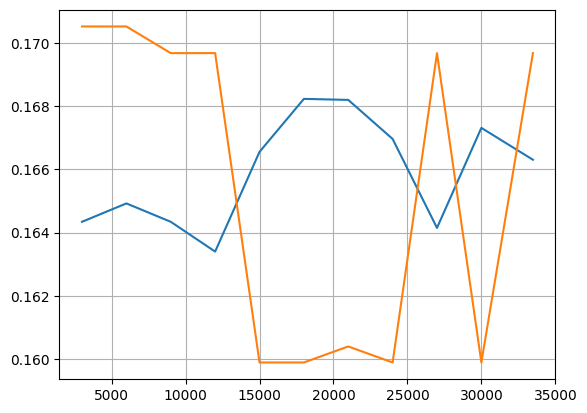

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100 
num_classes = 3
num_layers = 5
cell_type = 'LSTM'
hidden_size = 95
clip = 0.35
skip = False 
nonlinearity = 'tanh'
learning_rate = 0.29
dropout_rate = 0.1
num_epochs = 25

Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)

Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval, device=device)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)

Tscores = []
Vscores = []
for size in [3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33486,]:
    TrainDataset = torch.utils.data.TensorDataset(Xt[:size], Yt[:size])
    TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=64,shuffle=True)
     
    model = RNN(cell_type,input_size, hidden_size, num_layers,nonlinearity,dropout_rate, device, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        train_loss = train(model,TrainDataloader, criterion, optimizer, device, clip) 
    _, Ptrain = torch.max(model(Xt[:size]), 1)
    Ptrain = Ptrain.cpu()
    Ptraintrue = Yt.cpu()
    _, Ptest = torch.max(model(XT), 1)
    Ptest = Ptest.cpu()
    Ptesttrue = YT.cpu()
    Tscores+= [skf1(Ptraintrue[:size], Ptrain, average="weighted")]
    Vscores += [skf1(Ptesttrue, Ptest, average="weighted")]

plt.grid()
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33486], Tscores, label="Train Score")
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33486], Vscores, label="Test Score")
plt.show()



Vectorising Actual Test Data

In [20]:
#Vectorize Test_Set Data
def vectorize_test(df, model_name):
    X = []
    model = Word2Vec.load(model_name) 
    for (i, tweet) in enumerate(df['Text'].values):
        featureVec = np.zeros(100,dtype="float32")
        nwords = 0
        #Converting Index2Word which is a list to a set for better speed in the execution.
        index2word_set = set(model.wv.index_to_key)
        for word in word_tokenize(tweet):
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model.wv[word])
        # Dividing the result by number of words to get average
        if(nwords > 0):
            featureVec = np.divide(featureVec, nwords)
        X.append(featureVec) #we keep the mean 
    return X
X = vectorize_test(test_set,"word2vec.model")
X = torch.tensor(X, requires_grad=True)


Train model with best hyperparameters

In [21]:
device = torch.device('cpu')
input_size = 100 
num_classes = 3
num_layers = 3
cell_type = 'LSTM'
hidden_size = 19
clip = 1.0
skip = True
nonlinearity = 'tanh'
learning_rate = 0.01
dropout_rate = 0.15
num_epochs = 30
    
model = RNN(cell_type,input_size, hidden_size, num_layers,nonlinearity,dropout_rate, device, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_loss = train(model,TrainDataloader, criterion, optimizer, device, clip)

Predictions on Test_set and importing results to cvs file

In [22]:
#Predictions on Test_set and importing results to cvs file
model.eval()
pred = model(X)
_, predlabel = torch.max(pred.data, 1)
predlabel = predlabel.tolist()

predlabel = pd.DataFrame(predlabel)
predlabel.index = np.arange(predlabel.shape[0]) + 1
id = np.arange(predlabel.shape[0]) + 1
id = pd.DataFrame(id)
id.index = id.index + 1

predlabel = pd.concat([id,predlabel], axis=1)
predlabel.columns = ["Id", "Predicted"]
predlabel['Predicted'] = predlabel.Predicted.map({
    0:'POSITIVE',
    1:'NEUTRAL',
    2:'NEGATIVE'   
})
predlabel.to_csv('submission.csv', index= False)

Sources: 
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
https://discuss.pytorch.org/t/implementing-rnn-with-short-skip-connections-in-pytorch/193893
https://medium.com/swlh/a-simple-overview-of-rnn-lstm-and-attention-mechanism-9e844763d07b
https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
https://optuna.org/
https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html







https://github.com/sooftware/attentions

https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping